# Project Lighthouse 

#### Timeline: Feb 2022 - Nov 2022 @ HP
#### Description : To create Power BI dashboard and provide visualized reports for weekly supply change 

### Data Source

1. DSP reports - need to map material numbers, forecast and supply numbers from here
2. DSM reports - need to map consumption numbers from here 
3. WIF reports - need to map material numbers, forecast and supply numbers from here (for specific GTK model) 

### Modules and datafile settings

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import glob
import datetime

#find this week
today = datetime.date.today()
this_monday = today - datetime.timedelta(days=today.weekday())
#24 weeks as a planning cycle
week24 = this_monday + datetime.timedelta(days=161)
monday_str = this_monday.strftime("%m/%d/%Y")
monday_str2 = this_monday.strftime("%m%d")

### Use Path module to capture data source from sharepoints that synced with local computer

In [5]:
#create final df
df_final = pd.DataFrame()

#filepath
home = str(Path.home())
FIR_filepath = glob.glob(os.path.join(home, 'HP Inc', 'GTKSCP - BUIDM Dashboard', 'Data Source', 'DSP for Lighthouse - FIR.xlsx'))
DSM_filepath = glob.glob(os.path.join(home, 'HP Inc', 'GTKSCP - BUIDM Dashboard', 'Data Source',  'DSM*'))
FIR_Map_filepath = glob.glob(os.path.join(home, 'HP Inc', 'GTKSCP - DSP report', 'DT FIR - All PN List.xlsx'))
final_filepath = os.path.join(home, 'HP Inc', 'GTKSCP - BUIDM Dashboard', 'Data Source', 'BUIDM Data input.xlsx')

### Function 1 : Deal with DSM data source

In [12]:
def runDSM(filepath):

    df_DSM = pd.read_excel(filepath, sheet_name="Sheet1")
    df_grouped = df_DSM.groupby(['Feature Type [PRD]','Feature Value [PRD]', 'Location ID', 'Key Figure'])[monday_str].sum().reset_index()
    return df_grouped

### Function 2 : Deal with DSP data source

In [5]:
def runDSP(filepath):

    #import file
    df_DSP = pd.read_excel(filepath, sheet_name= "DSP HP view")

    #filter non-use rows
    df_filtered = df_DSP[~df_DSP['Key Figure'].isin(['WTD Deliveries',
                                             'Projected To Forecast HP View',
                                             'Buffer HP View',
                                             'Actual WOS HP View'])]

    #find p/n in DSP
    SAlist = df_filtered['Material Number'].unique()

    #filter p/n in DSM
    df_DSM = runDSM(DSM_filepath[0])
    df_DSM = df_DSM[df_DSM['Material Number'].isin(SAlist)]

    #merge
    df_merge = pd.concat([df_filtered, df_DSM], axis=0)

    #ffill/bfill NA values
    df_merge.sort_values(by=['Material Number', 'Key Figure'], inplace=True)
    df_merge['Ship From Loc Desc'] = df_merge['Ship From Loc Desc'].fillna(method='ffill')
    df_merge['Ship-To Location Desc'] = df_merge['Ship-To Location Desc'].fillna(method='ffill')

    #wrangling
    cols = df_merge.select_dtypes(float).columns
    df_merge[cols] = df_merge[cols].fillna(0)
    df_merge[cols] = df_merge[cols].astype(int)
    df_merge[cols] = df_merge[cols].round(0)

    #drop non-used columns
    df_merge.drop(columns=['Material Description', 'Version', 'Location ID', 'Project Code Name [CPK]'], inplace=True)

    #Change KF name
    df_merge.loc[(df_merge['Key Figure'] == 'Past Due Forecast HP View'), 'Key Figure'] = 'Forecast'
    df_merge.loc[(df_merge['Key Figure'] == 'Forecast HP View'), 'Key Figure'] = 'Forecast'
    df_merge.loc[(df_merge['Key Figure'] == 'Future Deliveries Total'), 'Key Figure'] = 'FD'
    df_merge.loc[(df_merge['Key Figure'] == 'FOI Available Qty'), 'Key Figure'] = 'FOI'
    df_merge.loc[(df_merge['Key Figure'] == 'HOI Non Visible Nettable'), 'Key Figure'] = 'HOI'
    df_merge.loc[(df_merge['Key Figure'] == 'WMAP Consumption'), 'Key Figure'] = 'Consumption'

    #Change column name
    df_merge.rename(columns={'Feature Type [PRD]': 'Feature Type'}, inplace=True)
    df_merge.rename(columns={'Feature Value [PRD]': 'Feature Value'}, inplace=True)
    df_merge.rename(columns={'Ship From Loc Desc': 'Ship From'}, inplace=True)
    df_merge.rename(columns={'Ship-To Location Desc': 'Ship To'}, inplace=True)

    #unpivot date
    df_unpivot = pd.melt(df_merge, id_vars=['Feature Type', 'Feature Value', 'Material Number', 'Ship From',
                                            'Ship To', 'Key Figure'], var_name='Plan Week', value_name='QTY')

    #date format
    df_unpivot['Plan Week'] = pd.to_datetime(df_unpivot['Plan Week']).dt.date

    #filter only FD / Forecast
    df_unpivot = df_unpivot.loc[(df_unpivot['Plan Week'] == this_monday) | (df_unpivot['Key Figure'] == 'Forecast') | (
                df_unpivot['Key Figure'] == 'FD')]

    #group pastdue forecast & forecast
    df_grouped = df_unpivot.groupby(['Feature Type', 'Feature Value', 'Material Number', 'Ship From',
                                     'Ship To', 'Key Figure', 'Plan Week'])[['QTY']].sum().reset_index()

    #Add ref week & category & map family
    df_grouped['Reference Week'] = this_monday

    #map platform from wif & mappingtable

    # wrangling mapping tables
    df_mapping = pd.read_excel(FIR_Map_filepath[0])
    df_mapping['Family code'] = df_mapping['Family code'].str.strip()
    df_mapping['SA#'] = df_mapping['SA#'].str.strip()
    df_mapping.drop_duplicates(subset=['SA#', 'Family code'], inplace=True)
    df_mapping = df_mapping.groupby(['SA#']).agg({'Family code': lambda x: '/'.join(x)}).reset_index()

    df_grouped['Category'] = 'FIR'
    df_grouped = df_grouped.merge(df_mapping[['SA#', 'Family code']], how="left", left_on='Material Number', right_on='SA#')
    df_grouped.drop(columns=['SA#'], inplace=True)
    df_grouped.rename(columns={'Family code': 'Platform'}, inplace=True)


    #date format
    df_grouped['Plan Week'] = pd.to_datetime(df_grouped['Plan Week']).dt.date
    df_grouped['Reference Week'] = pd.to_datetime(df_grouped['Reference Week']).dt.date

    #sorting
    df_grouped['Key Figure'] = pd.Categorical(df_grouped['Key Figure'],
                                              categories=['Forecast', 'FD', 'FOI', 'SOI', 'HOI', 'Consumption'])
    df_grouped.sort_values(by=["Material Number", "Ship To", "Reference Week", "Plan Week", "Key Figure"], inplace=True)

    #formatting
    df_grouped['Feature Value'] = df_grouped['Feature Value'].str.title()
    df_grouped['Ship From'] = df_grouped['Ship From'].str.title()
    df_grouped['Ship To'] = df_grouped['Ship To'].str.title()
    df_grouped['Platform'] = df_grouped['Platform'].str.upper()

    # merge to df_final
    global df_final
    df_final = pd.concat([df_final, df_grouped], axis=0, ignore_index=True)
    
    return df_final 

### Function 3 : Deal with WIF data source

In [6]:
def runL10():

    #WIFfilepath
    WIF_filepath = glob.glob(os.path.join(home, 'HP Inc', 'GTKSCP - Wed DSP', 'All*'))

    # find this week file
    for i in WIF_filepath:
        if monday_str2 in i:
            wif_file = i
            break
    wif_dict = pd.read_excel(wif_file, sheet_name=None)

    #concat all wif
    all_sheets = []
    for name, sheet in wif_dict.items():
        sheet.columns = ['Feature Type', 'Feature Value', 'Material Number', 'Plan Week', 'FD', 'Forecast', 'Platform']
        sheet['Ship To'] = name
        all_sheets.append(sheet)

    df_wif = pd.concat(all_sheets)
    df_wif.reset_index(inplace=True, drop=True)

    df_wif.to_excel(home + "\desktop\wif convert.xlsx", index=False)

    #wif wrangling
    df_wif['Plan Week'] = df_wif['Plan Week'].astype('datetime64[ns]')
    cols = df_wif.select_dtypes(float).columns
    df_wif[cols] = df_wif[cols].fillna(0)
    df_wif[cols] = df_wif[cols].astype(int)
    df_wif[cols] = df_wif[cols].round(0)

    cols = df_wif.select_dtypes(object).columns
    df_wif[cols] = df_wif[cols].fillna("")
    df_wif[cols] = df_wif[cols].apply(lambda x: x.str.strip())
    df_wif[cols] = df_wif[cols].apply(lambda x: x.str.upper())

    df_wif['Plan Week'] = pd.to_datetime(df_wif['Plan Week']).dt.date

    #filter
    df_filter = df_wif.loc[(df_wif['Feature Type'] == 'BASE UNIT') | (df_wif['Feature Type'] == 'IDMECHANICAL')]
    df_filter = df_filter.loc[df_wif['Plan Week'] <= week24 ]

    #Add ref week & ship from
    df_filter['Reference Week'] = this_monday
    df_filter['Ship From'] = df_filter['Ship To'].values

    #Finish wif wrangling

    #Map ship-to from rcto pn list

    #RCTO filepath
    RCTO_filepath = glob.glob(os.path.join(home, 'HP Inc', 'GTKSCP - DSP report', 'RCTO*'))
    #wrangling
    df_RCTO = pd.read_excel(RCTO_filepath[0], sheet_name="All")
    df_RCTO['SA#'] = df_RCTO['SA#'].str.strip()
    df_RCTO['Ship-to Location ID'] = df_RCTO['Ship-to Location ID'].str.strip()
    df_RCTO.drop_duplicates(subset=['SA#', 'Ship-to Location ID'], inplace=True)


    #Check RCTO & Add Category
    RCTOlist = df_RCTO['SA#'].unique()
    df_filter['Category'] = np.where(df_filter['Material Number'].isin(RCTOlist), "RCTO", "L10")

    #Merge RCTO ship-to location
    df_merge = df_filter.merge(df_RCTO[['SA#', 'Ship-to Location ID']], left_on=['Material Number'], right_on=['SA#'], how='left')

    #Change Ship from
    df_merge.loc[(df_merge['Category'] == 'L10'), 'Ship From'] = ""
    df_merge.loc[(df_merge['Category'] == 'RCTO'), 'Ship To'] = df_merge.loc[(df_merge['Category'] == 'RCTO')]['Ship-to Location ID'].values
    df_merge.drop(columns=['SA#', 'Ship-to Location ID'], inplace=True)

    # Map consumption from dsm

    #find p/n in DSP
    SAlist = df_merge['Material Number'].unique()

    #filter p/n in DSM
    df_DSM = runDSM(DSM_filepath[0])
    df_DSM = df_DSM[df_DSM['Material Number'].isin(SAlist)]

    #merge_DSM
    df_merge2 = df_merge.merge(df_DSM[['Material Number', 'Location ID', monday_str]], how="left", left_on = ['Material Number', 'Ship To'], right_on = ['Material Number', 'Location ID'])

    #drop non-used columns
    df_merge2.drop(columns=['Location ID'], inplace=True)
    df_merge2.rename(columns={monday_str: 'Consumption'}, inplace=True)
    df_merge2['Consumption'] = df_merge2['Consumption'].fillna(0)
    df_merge2['Consumption'] = df_merge2['Consumption'].astype(int)
    df_merge2['Consumption'] = df_merge2['Consumption'].round(0)

    df_merge2['Reference Week'] = df_merge2['Reference Week'].astype('datetime64[ns]')
    df_merge2['Reference Week'] = pd.to_datetime(df_merge2['Reference Week']).dt.date

    #unpivot
    df_unpivot = pd.melt(df_merge2, id_vars=['Material Number', 'Feature Type', 'Feature Value', 'Ship From',
                                             'Ship To', 'Platform', 'Reference Week', 'Plan Week', 'Category'],
                         var_name='Key Figure', value_name='QTY')

    df_unpivot = df_unpivot.loc[(df_unpivot['Plan Week'] == this_monday) | (df_unpivot['Key Figure'] == 'FD') | (
                df_unpivot['Key Figure'] == 'Forecast')]

    #Change Name
    df_unpivot.loc[(df_unpivot['Ship To'] == '01DZ'), 'Ship To'] = 'Pegatron Chongqing'
    df_unpivot.loc[(df_unpivot['Ship To'] == '00CV'), 'Ship To'] = 'Quanta Chongqing'
    df_unpivot.loc[(df_unpivot['Ship To'] == '01CE'), 'Ship To'] = 'Wistron Chongqing'
    df_unpivot.loc[(df_unpivot['Ship To'] == '0940'), 'Ship To'] = 'Compal Kun Shan'
    df_unpivot.loc[(df_unpivot['Ship To'] == '0035'), 'Ship To'] = 'Foxconn Longhua'
    df_unpivot.loc[(df_unpivot['Ship To'] == '01DJ'), 'Ship To'] = 'Foxconn Wuhan'
    df_unpivot.loc[(df_unpivot['Ship To'] == '0905'), 'Ship To'] = 'Inventec Chongqing'
    df_unpivot.loc[(df_unpivot['Ship To'] == '01DF'), 'Ship To'] = 'Inventec Taiwan'
    df_unpivot.loc[(df_unpivot['Ship To'] == 'JP51'), 'Ship To'] = 'HP Japan'
    df_unpivot.loc[(df_unpivot['Ship To'] == 'XG01'), 'Ship To'] = 'HP India - Flex Chennai Mfg'

    df_unpivot.loc[(df_unpivot['Ship From'] == '00CV'), 'Ship From'] = 'Quanta Chongqing'
    df_unpivot.loc[(df_unpivot['Ship From'] == '0940'), 'Ship From'] = 'Compal Kun Shan'
    df_unpivot.loc[(df_unpivot['Ship From'] == '0905'), 'Ship From'] = 'Inventec Chongqing'

    #formatting
    df_unpivot.sort_values(by=["Material Number", "Ship To", "Reference Week", "Plan Week", "Key Figure"], inplace=True)

    df_unpivot['Feature Value'] = df_unpivot['Feature Value'].str.title()
    df_unpivot['Ship From'] = df_unpivot['Ship From'].str.title()
    df_unpivot['Ship To'] = df_unpivot['Ship To'].str.title()
    df_unpivot['Platform'] = df_unpivot['Platform'].str.upper()

    #df_unpivot.to_excel(home + "\desktop\wif convert.xlsx", index=False)

    #merge to df_final
    global df_final
    df_final = pd.concat([df_final, df_unpivot], axis=0, ignore_index=True)
    
    return df_final

### Run files (will run different functions according to the procurement model for different components)

In [1]:
#run file

#runDSM(DSM_filepath[0])
#runL10()
#runDSP(FIR_filepath[0])

### Data after cleaning

In [6]:
df_final = pd.read_excel(final_filepath, sheet_name="Sheet1")

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197923 entries, 0 to 197922
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Material Number  197923 non-null  object        
 1   Feature Type     197923 non-null  object        
 2   Feature Value    197923 non-null  object        
 3   Ship From        35341 non-null   object        
 4   Ship To          197923 non-null  object        
 5   Platform         197923 non-null  object        
 6   Reference Week   197923 non-null  datetime64[ns]
 7   Plan Week        197923 non-null  datetime64[ns]
 8   Key Figure       197923 non-null  object        
 9   QTY              197923 non-null  int64         
 10  Category         197923 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 16.6+ MB


### Export Data from MS Database

In [7]:
import pyodbc

home = str(Path.home())
filepath = os.path.join(home, 'HP Inc', 'GTKSCP - GFX', 'Data Source',  'GFX Waterfall.accdb')

try:
    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=%s;' %filepath)
    print("Connected to MS Access")

except pyodbc.Error as e:
    print("Error in connection", e)

query = "SELECT * FROM GFX"
df = pd.read_sql(query, conn)

conn.close()

Connected to MS Access


In [8]:
#find this week
today = datetime.date.today()
this_monday = today - datetime.timedelta(days=today.weekday())
cut_date = datetime.datetime(today.year, today.month - 1, 1)

#this_monday = this_monday - datetime.timedelta(days=7)
last_monday = this_monday - datetime.timedelta(days=7)
week24 = this_monday + datetime.timedelta(days=161)

### Function for final data processing and export

In [9]:
def data_export():
    
    df_filter = df.loc[df['Reference Week'] >= cut_date]
    df_filter['Ship From'] = df_filter['Ship From'].fillna('')
    #df_filter['Reference Week'].unique()
    
    pivot_list = ["Material Number", "Feature Type", "Feature Value", "Ship From", "Ship To", "Platform","Plan Week", "Category", "Reference Week", "Key Figure"]
    pivot_list1 = ["Material Number", "Feature Type", "Feature Value", "Ship From", "Ship To", "Platform","Plan Week", "Category", "Reference Week"]
    
    df_filter.loc[(df_filter['Key Figure'] == 'FD'), 'Key Figure'] = 'TSV'
    df_filter.loc[(df_filter['Key Figure'] == 'FOI'), 'Key Figure'] = 'TSV'
    df_filter.loc[(df_filter['Key Figure'] == 'SOI'), 'Key Figure'] = 'TSV'
    df_filter.loc[(df_filter['Key Figure'] == 'HOI'), 'Key Figure'] = 'TSV'
    
    #group pastdue forecast & forecast
    df_group = df_filter.groupby(pivot_list)[['QTY']].sum().reset_index()
    
    #date format
    df_group['Plan Week'] = pd.to_datetime(df_group['Plan Week']).dt.date
    df_group['Reference Week'] = pd.to_datetime(df_group['Reference Week']).dt.date
    
    df_pivot = df_group.pivot(index = pivot_list1,columns = 'Key Figure', values = 'QTY')
    df_pivot = df_pivot.fillna(0)
    df_pivot.columns.name = None
    df_pivot = df_pivot.reset_index()
    
    #print(df_pivot)
    
    df_filter2 = df_group.loc[(df_group['Reference Week'] == this_monday) | (df_group['Reference Week'] == last_monday)]
    
    # find different platform
    df_diff = df_filter2.drop_duplicates(subset = ["Material Number", "Feature Type", "Feature Value", "Ship From",
                                                   "Ship To", "Platform","Plan Week", "Category"], keep=False)
    
    #print(df_diff)
    
    df_filter2.loc[(df_filter2['Key Figure'] == 'Consumption') & (df_filter2['Reference Week'] == last_monday), 'QTY'] = 0
    
    df_filter2 = df_filter2.set_index(pivot_list)
    df_filter2 = df_filter2.unstack().unstack()
    df_filter2.columns = df_filter2.columns.droplevel(0)
    df_filter2 = df_filter2.fillna(0)
    
    df_subt = df_filter2.loc[:, pd.IndexSlice[:,this_monday]] - df_filter2.loc[:, pd.IndexSlice[:,last_monday]].values
    df_demandchange = df_subt["Consumption"] + df_subt["Forecast"].values
    df_supplychange = df_subt["Consumption"] + df_subt["TSV"].values
    
    #print(df_subt)
    
    df_demandchange.columns.name = None
    df_demandchange = df_demandchange.reset_index()
    df_demandchange.rename(columns={df_demandchange.columns[8]: 'Demand Change'},inplace=True)
    
    df_supplychange.columns.name = None
    df_supplychange = df_supplychange.reset_index()
    df_supplychange.rename(columns={df_supplychange.columns[8]: 'Supply Change'},inplace=True)
    
    df_demandchange['Reference Week'] = this_monday
    df_supplychange['Reference Week'] = this_monday
    
    df_merge = df_demandchange.merge(df_supplychange, on = ["Material Number", "Feature Type", "Feature Value", "Ship From", "Ship To", "Platform","Plan Week", "Category", "Reference Week"],how="left")
    
    df_merge.loc[(df_merge['Plan Week'] == last_monday), 'Plan Week'] = this_monday
    
    df_group2 = df_merge.groupby(pivot_list1)[['Demand Change', 'Supply Change']].sum().reset_index()
    
    
    df_merge2 = df_pivot.merge(df_group2, on = ["Material Number", "Feature Type", "Feature Value", "Ship From", "Ship To", "Platform","Plan Week", "Category", "Reference Week"],how="left")
    df_merge2.sort_values(by=["Material Number", "Ship To", "Reference Week", "Plan Week"], inplace=True)
    df_merge2['Cumulative Supply Change'] = df_merge2.groupby(['Material Number', 'Ship To'])['Supply Change'].cumsum()
    df_merge2['Cumulative Demand Change'] = df_merge2.groupby(['Material Number', 'Ship To'])['Demand Change'].cumsum()
    df_merge2['TSV delta to Forecast'] = df_merge2['TSV'] - df_merge2['Forecast']
    df_merge2['Cumulative TSV delta to Forecast'] =  df_merge2.groupby(["Material Number", "Ship To", "Reference Week"])['TSV delta to Forecast'].cumsum()
    df_merge2['Cumulative TSV'] =  df_merge2.groupby(["Material Number", "Ship To", "Reference Week"])['TSV'].cumsum()
    df_merge2['Cumulative Forecast'] =  df_merge2.groupby(["Material Number", "Ship To", "Reference Week"])['Forecast'].cumsum()
    
    #df_merge2['Cumulative Supply Change'] = df_merge2['Cumulative Supply Change'].fillna(0)
    #df_merge2['Cumulative Demand Change'] = df_merge2['Cumulative Demand Change'].fillna(0)
    
    #reorganize
    df_merge2 = df_merge2[['Material Number', 'Feature Type', 'Feature Value', 'Ship From', 'Ship To', 'Platform', 'Reference Week','Plan Week','Category','Consumption','Forecast','Cumulative Forecast','TSV','Cumulative TSV',
                           'TSV delta to Forecast','Cumulative TSV delta to Forecast','Demand Change','Cumulative Demand Change','Supply Change', 'Cumulative Supply Change']]
    
    #df_merge2.to_excel(home+"\Desktop\Data Output.xlsx", index=False)
    df_merge2.to_excel(home+"\HP Inc\GTKSCP - BUIDM Dashboard\Data Source\BUIDM Data output.xlsx", index=False)

In [10]:
output_filepath = os.path.join(home, 'HP Inc', 'GTKSCP - BUIDM Dashboard', 'Data Source', 'BUIDM Data output.xlsx')

df_final2 = pd.read_excel(output_filepath, sheet_name="Sheet1")

df_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634472 entries, 0 to 634471
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Material Number                   634472 non-null  object        
 1   Feature Type                      634472 non-null  object        
 2   Feature Value                     634472 non-null  object        
 3   Ship From                         114334 non-null  object        
 4   Ship To                           634472 non-null  object        
 5   Platform                          634472 non-null  object        
 6   Reference Week                    634472 non-null  datetime64[ns]
 7   Plan Week                         634472 non-null  datetime64[ns]
 8   Category                          634472 non-null  object        
 9   Consumption                       634472 non-null  int64         
 10  Forecast                        

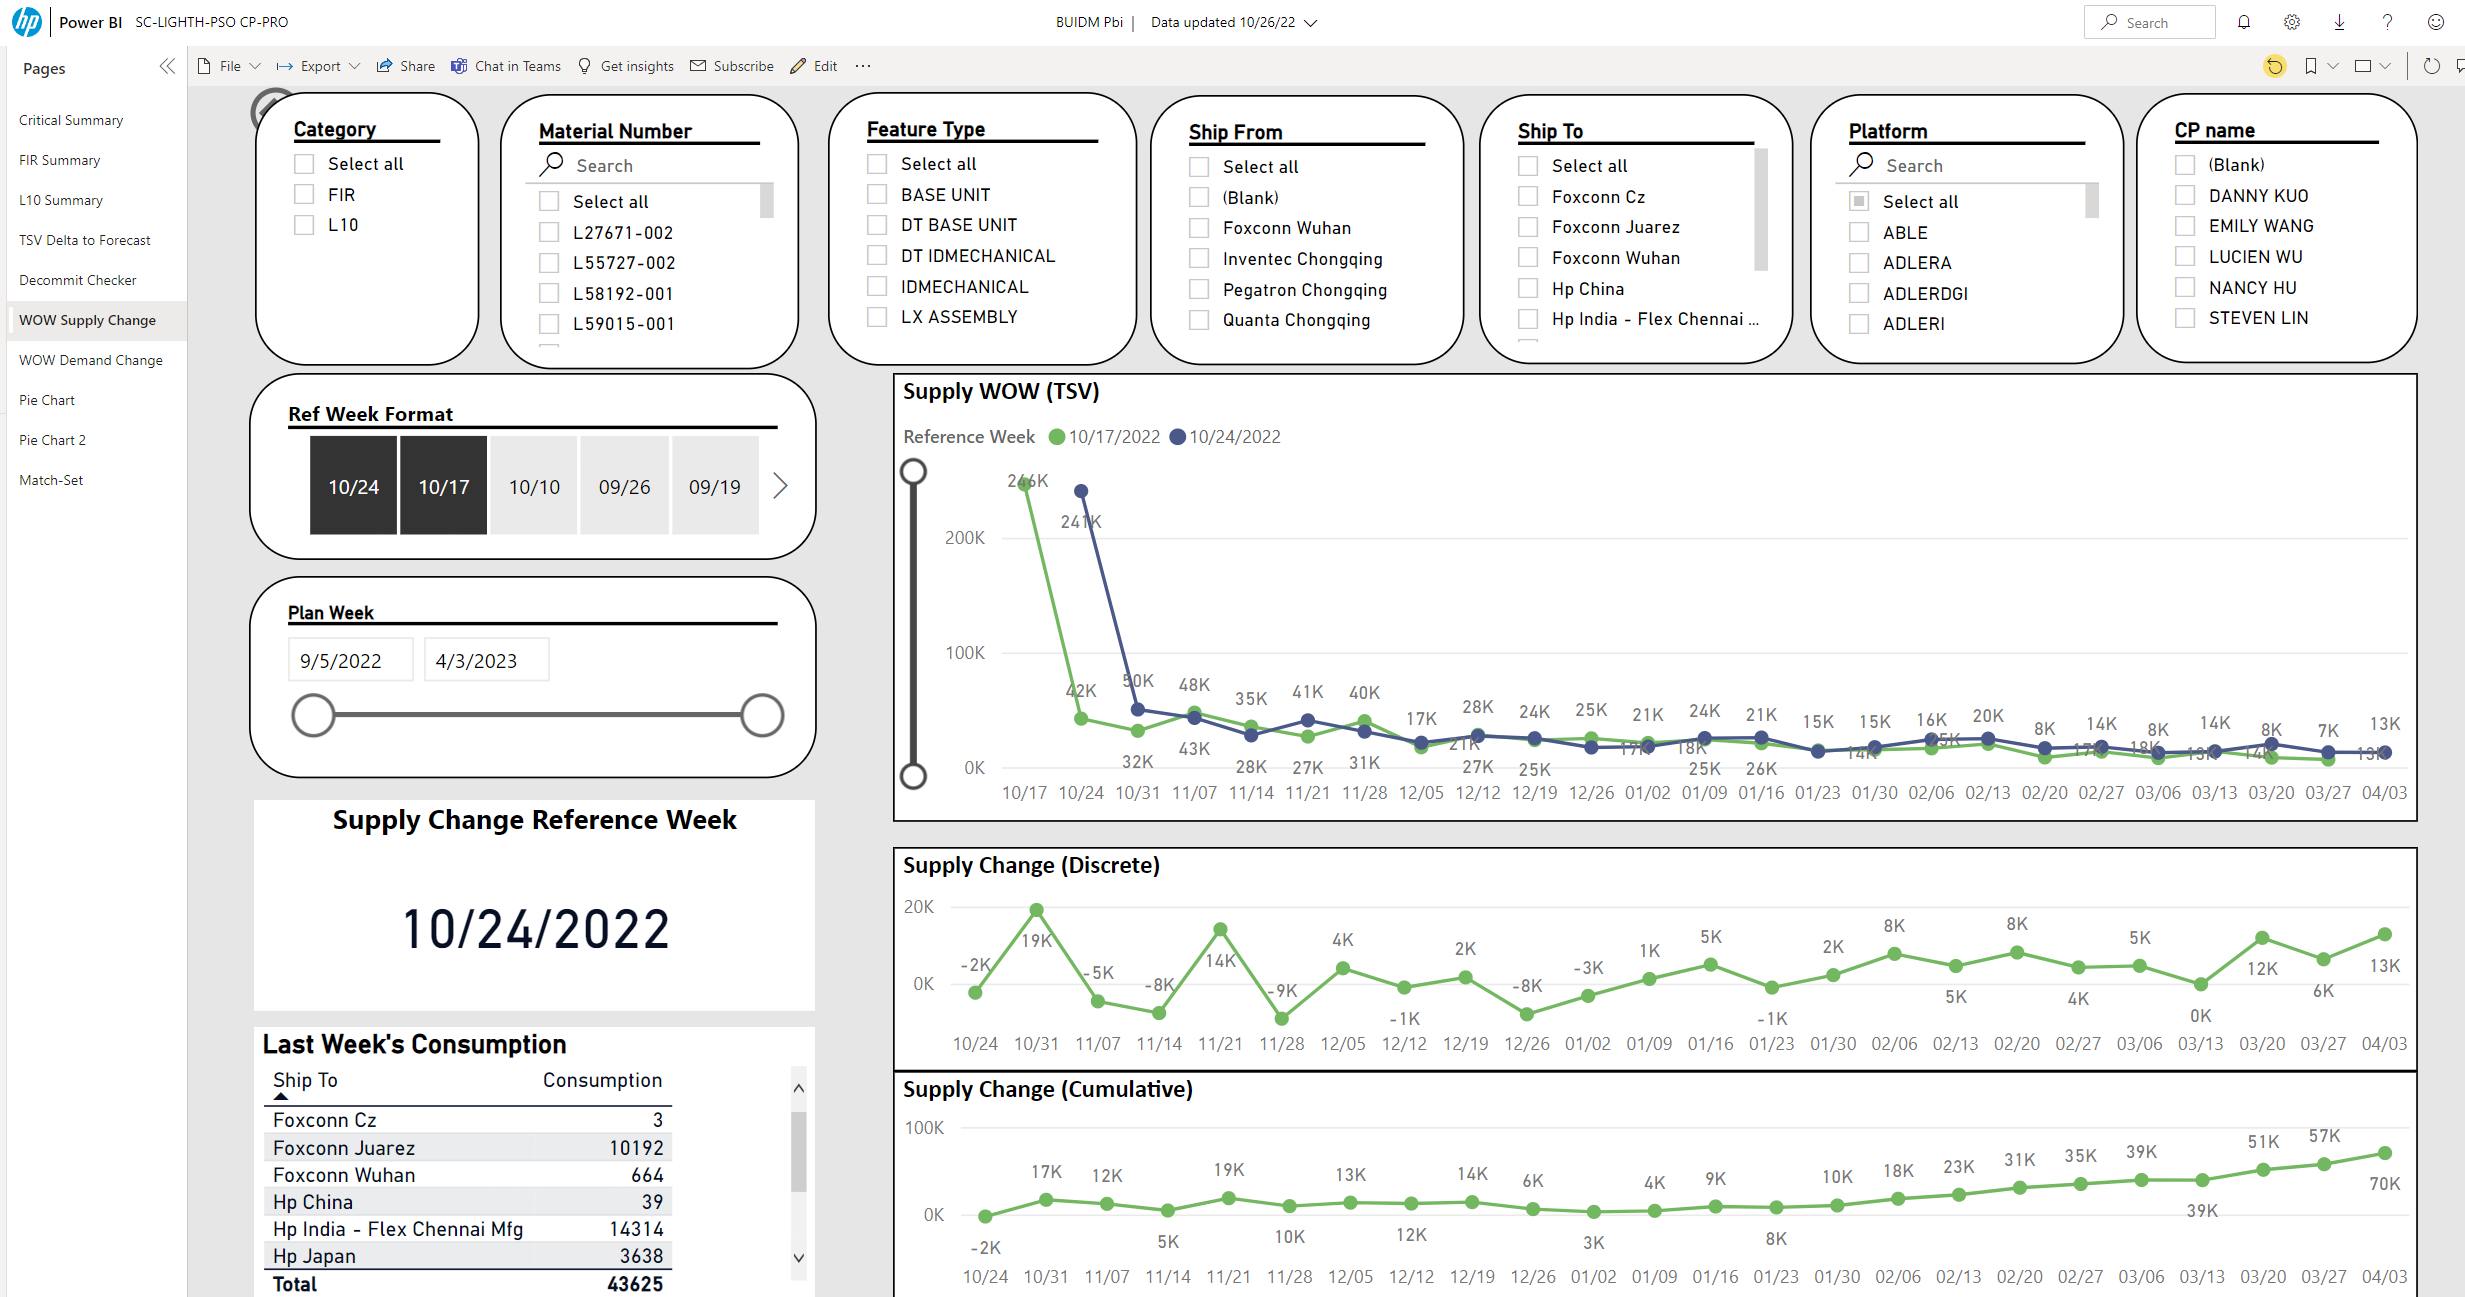